# Single item characterisation plots

Collection of random plots for chapter 4.



In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data

import re
import inspect
import imp

import utils
import load_experimental_data
import highdimensionnetwork
import hierarchicalrandomnetwork

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

## Fisher Information comparison

OLD STUFF WAS:
* Fisher Information stuff is in: [../fisherinfo_new_2016/notebook_fisher_fits_2016.ipynb](../fisherinfo_new_2016/notebook_fisher_fits_2016.ipynb)
* Fisher Information, 2d plots are in: [../fisherinfo_new_2016/notebook_fisher_random_large_2try_310816.ipynb](../fisherinfo_new_2016/notebook_fisher_random_large_2try_310816.ipynb)


### single network plot

Use large sweep from `generator_fisher2016_random_Mratio_5try_240818.py`. 

Reloaded in [this notebook](../fisherinfo_new_2016/notebook_fisher2016_random_Mratio_5try_240818.ipynb)

## 2d plot ratio / M

Also in [same notebook](../fisherinfo_new_2016/notebook_fisher2016_random_Mratio_5try_240818.ipynb)

## Coverage of space effect 

Used in section 4.2.2 Coverage of space. Shows the dependence of the memory fidelity and average activation on the optimal density

### population M=100

In [28]:
arguments_dict = dict(
    action_to_do='launcher_do_simple_run',
    inference_method='sample',
    N=100,
    num_samples=50,
    M=10**2,
    label='thesis_fisherinfo_fit_1obj_smallM',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_1obj_050816',
    T=3,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
    code_type='conj',
    ratio_conj=1.,
    sigmax=0.1,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.017,
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
    sampler = experiment_launcher.all_vars['sampler']
    network = sampler.random_network

optimal_rc_scale = network.rc_scale[0]
print(optimal_rc_scale)

3.15576171875


In [29]:
dataio = DataIO(label='tiling_space_effect_M100', 
                calling_function='', 
                output_folder=os.environ['WORKDIR_DROP'] + '/Figures/thesis/single_item_characterisation')

=== FileIO ready: /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Figures/thesis/single_item_characterisation/tiling_space_effect_M100-36cf5b3c-3276-48e3-8a7e-0d8b716c568c ===


In [30]:
def do_plot(network, ax=None):
    (mean_activity, feature_space1, feature_space2) = network.get_mean_activity(precision=100, return_axes_vect=True)
    activ_mean = np.mean(mean_activity)
    activ_std = np.std(mean_activity.flatten())

    cmap_div = sns.diverging_palette(h_neg=29, h_pos=265, s=80, l=85, sep=1, as_cmap=True, center='dark')
    eps = max(4*activ_std, 1e-3)
    # eps = activ_mean*1e-5

    ax, im = utils.pcolor_2d_data(mean_activity, x=feature_space1, y=feature_space2, 
                                  xlabel='Color', ylabel='Orientation', 
                                  colorbar=True, ticks_interpolate=5, 
                                  cmap="RdBu_r",
                                  vmin=max(activ_mean - eps, 0), vmax=min(activ_mean + eps, 1),
                                  ax_handle=ax
                                 )
    ax.set_xticklabels((r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'), rotation=0, fontsize=18)
    ax.set_yticklabels((r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'), rotation=0)
    
    return ax

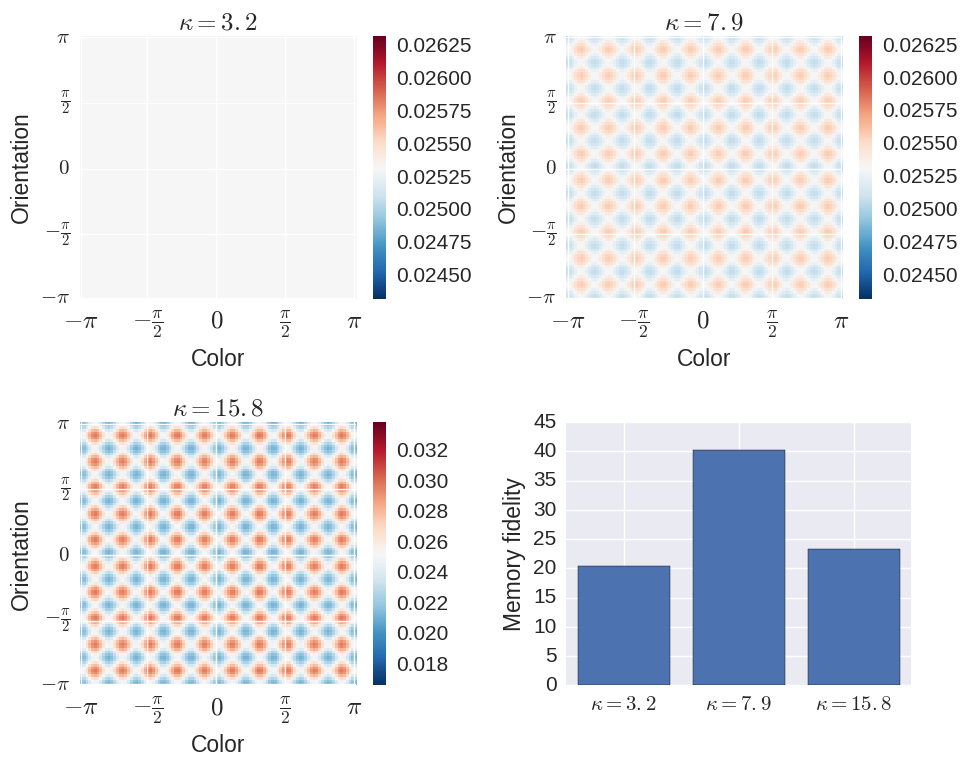

In [31]:
# Do all plots for given rcscales:
# rcscale_space = np.array([4.23, 2.9*4.23, 6*4.23])
rcscale_space = np.array([optimal_rc_scale, 2.5*optimal_rc_scale, 5*optimal_rc_scale])

f, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

mem_fidelities = np.zeros_like(rcscale_space)

for rcscale_i, rcscale in enumerate(rcscale_space):
    arguments_dict['rc_scale'] = rcscale
    if 'autoset_parameters' in arguments_dict:
        del arguments_dict['autoset_parameters']
    with io.capture_output(display=False, stdout=True) as captured:
        experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
        sampler = experiment_launcher.all_vars['sampler']
        do_plot(sampler.random_network, axes[rcscale_i])

        axes[rcscale_i].set_title("$\kappa = %.1f$" % rcscale)
        
        mem_fidelities[rcscale_i] = sampler.fit_mixture_model()['kappa']

axes[-1].bar([1, 2, 3], mem_fidelities, align="center")
axes[-1].set_xticks([1, 2, 3])
axes[-1].set_xticklabels(["$\kappa = %.1f$" % rcscale for rcscale in rcscale_space])
axes[-1].set_ylabel("Memory fidelity")

plt.tight_layout()

# f.savefig(dataio.create_formatted_filename("tiling_kappa_effect_{label}_{unique_id}.pdf"))

In [21]:
(mean_activity, feature_space1, feature_space2) = sampler.random_network.get_mean_activity(precision=100, return_axes_vect=True)
activ_mean = np.mean(mean_activity)
activ_std = np.std(mean_activity.flatten())


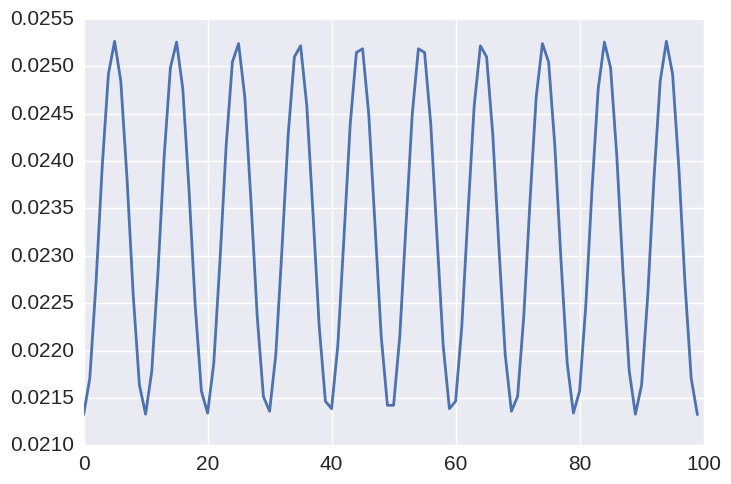

In [27]:
plt.plot(mean_activity[50])

### Population N=36

In [9]:
arguments_dict = dict(
    action_to_do='launcher_do_simple_run',
    inference_method='sample',
    N=100,
    num_samples=50,
    M=6**2,
    label='thesis_fisherinfo_fit_1obj_smallM',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_1obj_050816',
    T=1,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
#     rc_scale=1.428,
    code_type='conj',
    ratio_conj=1.,
    sigmax=0.1,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
    sampler = experiment_launcher.all_vars['sampler']
    network = sampler.random_network

optimal_rc_scale = network.rc_scale[0]
print(optimal_rc_scale)

1.42841796875


In [10]:
dataio = DataIO(label='tiling_space_effect_M36', 
                calling_function='', 
                output_folder=os.environ['WORKDIR_DROP'] + '/Figures/thesis/single_item_characterisation')

=== FileIO ready: /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Figures/thesis/single_item_characterisation/tiling_space_effect_M36-759b65f8-6b8a-4ec7-95d9-cacad8e4a4b1 ===


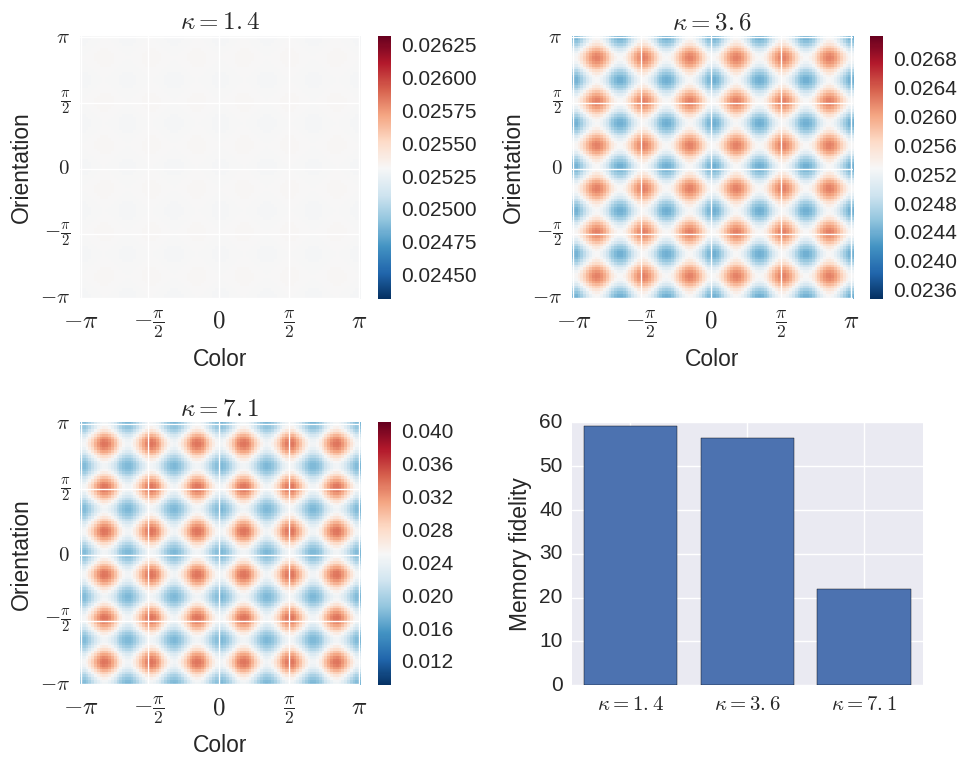

In [11]:
# Do all plots for given rcscales:
# rcscale_space = np.array([4.23, 2.9*4.23, 6*4.23])
rcscale_space = np.array([optimal_rc_scale, 2.5*optimal_rc_scale, 5*optimal_rc_scale])

f, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

mem_fidelities = np.zeros_like(rcscale_space)

for rcscale_i, rcscale in enumerate(rcscale_space):
    arguments_dict['rc_scale'] = rcscale
    if 'autoset_parameters' in arguments_dict:
        del arguments_dict['autoset_parameters']
    with io.capture_output(display=False, stdout=True) as captured:
        experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
        sampler = experiment_launcher.all_vars['sampler']
        do_plot(sampler.random_network, axes[rcscale_i])

        axes[rcscale_i].set_title("$\kappa = %.1f$" % rcscale)
        
        mem_fidelities[rcscale_i] = sampler.fit_mixture_model()['kappa']

axes[-1].bar([1, 2, 3], mem_fidelities, align="center")
axes[-1].set_xticks([1, 2, 3])
axes[-1].set_xticklabels(["$\kappa = %.1f$" % rcscale for rcscale in rcscale_space])
axes[-1].set_ylabel("Memory fidelity")

plt.tight_layout()

# f.savefig(dataio.create_formatted_filename("tiling_kappa_effect_{label}_{unique_id}.pdf"))

## Encoding noise effect

In [50]:
arguments_dict = dict(
    action_to_do='launcher_do_simple_run',
    inference_method='sample',
    N=100,
    num_samples=50,
    M=6**2,
    label='thesis_encodingnoiseeffect_smallM',
    output_directory=os.environ['WORKDIR_DROP'] + '/Figures/thesis/single_item_characterisation',
    T=1,
    num_repetitions=1,
    renormalize_sigma=None,
    autoset_parameters=None,
    code_type='conj',
    ratio_conj=1.,
    sigmax=0.1,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
    sampler = experiment_launcher.all_vars['sampler']
    network = sampler.random_network



In [139]:
dataio = DataIO(label='encodingnoise_M36', 
                calling_function='', 
                output_folder=os.environ['WORKDIR_DROP'] + '/Figures/thesis/single_item_characterisation')

=== FileIO ready: /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Figures/thesis/single_item_characterisation/encodingnoise_M36-181d5379-d10c-4217-8d8b-c06895f32e21 ===


In [125]:
sigmax2_space = 0.5*np.logspace(-4, 0, 50)

mem_fidelities = np.zeros_like(sigmax2_space)
precisions = np.zeros_like(sigmax2_space)
fisherinfos = np.zeros_like(sigmax2_space)

for sigmax_i, sigmax2 in enumerate(sigmax2_space):
    print "Sigmax:", sigmax2
    arguments_dict['sigmax'] = sigmax2**0.5
    with io.capture_output(display=False, stdout=True) as captured:
        experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
        sampler = experiment_launcher.all_vars['sampler']
        
        mem_fidelities[sigmax_i] = sampler.fit_mixture_model()['kappa']
        precisions[sigmax_i] = sampler.get_precision()
        fisherinfos[sigmax_i] = sampler.estimate_fisher_info_from_posterior_avg_randomsubset(subset_size=10)

Sigmax: 5e-05
Sigmax: 6.0339632032e-05
Sigmax: 7.28174238751e-05
Sigmax: 8.78755312427e-05
Sigmax: 0.000106047544396
Sigmax: 0.000127977396135
Sigmax: 0.000154442179824
Sigmax: 0.000186379686016
Sigmax: 0.000224921633448
Sigmax: 0.000271433771966
Sigmax: 0.00032756427843
Sigmax: 0.000395302160545
Sigmax: 0.000477047738175
Sigmax: 0.000575697699663
Sigmax: 0.000694747747187
Sigmax: 0.000838416468406
Sigmax: 0.00101179482386
Sigmax: 0.00122102654727
Sigmax: 0.00147352585128
Sigmax: 0.00177824015311
Sigmax: 0.00214596713006
Sigmax: 0.00258973733962
Sigmax: 0.00312527596264
Sigmax: 0.00377156003168
Sigmax: 0.00455149088996
Sigmax: 0.00549270570994
Sigmax: 0.00662855682795
Sigmax: 0.00799929359803
Sigmax: 0.00965348864442
Sigmax: 0.0116497590526
Sigmax: 0.0140588434899
Sigmax: 0.0169661088595
Sigmax: 0.0204745753119
Sigmax: 0.0247085668066
Sigmax: 0.029818116583
Sigmax: 0.0359842836501
Sigmax: 0.0434255686876
Sigmax: 0.0524056567077
Sigmax: 0.0632427608428
Sigmax: 0.0763208983588
Sigmax: 0.

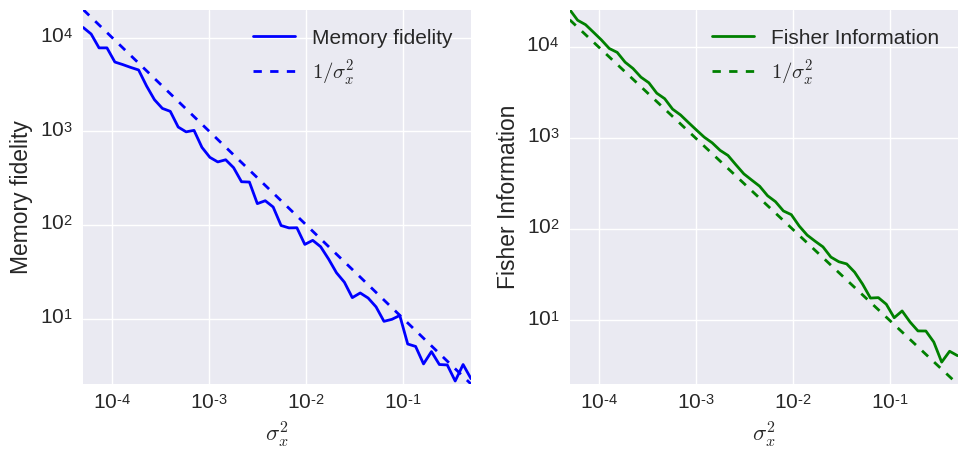

In [141]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].loglog(sigmax2_space, mem_fidelities, 'b', sigmax2_space, sigmax2_space**-1., 'b--')
axes[0].set_xlabel('$\sigma_x^2$')
axes[0].set_ylabel('Memory fidelity')
axes[0].legend(["Memory fidelity", "$1/\sigma_x^2$"])
axes[0].autoscale(enable=True, tight=True)

axes[1].loglog(sigmax2_space, fisherinfos, 'g')
axes[1].loglog(sigmax2_space, sigmax2_space**-1., 'g--')
axes[1].set_xlabel('$\sigma_x^2$')
axes[1].set_ylabel('Fisher Information')
axes[1].legend(["Fisher Information", "$1/\sigma_x^2$"])
axes[1].autoscale(enable=True, tight=True)

plt.tight_layout()

f.savefig(dataio.create_formatted_filename("encoding_noise_effect_{label}_{unique_id}.pdf"))